In [1]:
import torch
import torch.nn as nn
from collections import defaultdict
import pandas as pd
import h5py
from sklearn.metrics import log_loss

import cv2

import models
import os
from Dataset import Dataset
from torch.autograd.variable import Variable
import numpy as np

from util_moduls.Utils import get_device

from lib.NCEAverage import NCEAverage
from lib.NCECriterion import NCECriterion
%matplotlib inline
import matplotlib.pyplot as plt
import time
from test import NN, kNN
from scipy import misc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def resize2d(img, size):
    return (torch.nn.functional.adaptive_avg_pool2d(Variable(img,requires_grad=False), size)).data

In [3]:
low_dim = 128
checkpoint = torch.load('model_best.pth.tar')
model = models.__dict__[checkpoint['arch']](n_frames=6,low_dim=low_dim)
model = model.cuda()
model = torch.nn.DataParallel(model)

/usr/local/lib/python2.7/dist-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [4]:
state_dict = checkpoint['state_dict']

In [5]:
from collections import OrderedDict

print('epoch: {}'.format(checkpoint['epoch']))

lemniscate = checkpoint['lemniscate']

model.load_state_dict(state_dict)           


epoch: 11


In [6]:
training_file = "/home/sascha/for_bdd_training/full_train_set_v2.hdf5"
validation_file = "/home/sascha/for_bdd_training/full_val_set_v2.hdf5"

In [7]:
# Keep 25% of the memory free for writing data into the dictionary.
keep_memory_free=25
preload_to_mem=False
# In this order the whole val dataset should be loaded into memory and a part of the training set
val_dataset = Dataset(validation_file,preload_to_mem=preload_to_mem,keep_memory_free=keep_memory_free)
train_dataset = Dataset(training_file,preload_to_mem=preload_to_mem,keep_memory_free=keep_memory_free)

Loading /home/sascha/for_bdd_training/full_val_set_v2.hdf5
The file exists: True
Loading hdf5 key 0 from 9048
Loading hdf5 key 100 from 9048
Loading hdf5 key 200 from 9048
Loading hdf5 key 300 from 9048
Loading hdf5 key 400 from 9048
Loading hdf5 key 500 from 9048
Loading hdf5 key 600 from 9048
Loading hdf5 key 700 from 9048
Loading hdf5 key 800 from 9048
Loading hdf5 key 900 from 9048
Loading hdf5 key 1000 from 9048
Loading hdf5 key 1100 from 9048
Loading hdf5 key 1200 from 9048
Loading hdf5 key 1300 from 9048
Loading hdf5 key 1400 from 9048
Loading hdf5 key 1500 from 9048
Loading hdf5 key 1600 from 9048
Loading hdf5 key 1700 from 9048
Loading hdf5 key 1800 from 9048
Loading hdf5 key 1900 from 9048
Loading hdf5 key 2000 from 9048
Loading hdf5 key 2100 from 9048
Loading hdf5 key 2200 from 9048
Loading hdf5 key 2300 from 9048
Loading hdf5 key 2400 from 9048
Loading hdf5 key 2500 from 9048
Loading hdf5 key 2600 from 9048
Loading hdf5 key 2700 from 9048
Loading hdf5 key 2800 from 9048
Loa

Loading hdf5 key 15800 from 61272
Loading hdf5 key 15900 from 61272
Loading hdf5 key 16000 from 61272
Loading hdf5 key 16100 from 61272
Loading hdf5 key 16200 from 61272
Loading hdf5 key 16300 from 61272
Loading hdf5 key 16400 from 61272
Loading hdf5 key 16500 from 61272
Loading hdf5 key 16600 from 61272
Loading hdf5 key 16700 from 61272
Loading hdf5 key 16800 from 61272
Loading hdf5 key 16900 from 61272
Loading hdf5 key 17000 from 61272
Loading hdf5 key 17100 from 61272
Loading hdf5 key 17200 from 61272
Loading hdf5 key 17300 from 61272
Loading hdf5 key 17400 from 61272
Loading hdf5 key 17500 from 61272
Loading hdf5 key 17600 from 61272
Loading hdf5 key 17700 from 61272
Loading hdf5 key 17800 from 61272
Loading hdf5 key 17900 from 61272
Loading hdf5 key 18000 from 61272
Loading hdf5 key 18100 from 61272
Loading hdf5 key 18200 from 61272
Loading hdf5 key 18300 from 61272
Loading hdf5 key 18400 from 61272
Loading hdf5 key 18500 from 61272
Loading hdf5 key 18600 from 61272
Loading hdf5 k

Loading hdf5 key 39500 from 61272
Loading hdf5 key 39600 from 61272
Loading hdf5 key 39700 from 61272
Loading hdf5 key 39800 from 61272
Loading hdf5 key 39900 from 61272
Loading hdf5 key 40000 from 61272
Loading hdf5 key 40100 from 61272
Loading hdf5 key 40200 from 61272
Loading hdf5 key 40300 from 61272
Loading hdf5 key 40400 from 61272
Loading hdf5 key 40500 from 61272
Loading hdf5 key 40600 from 61272
Loading hdf5 key 40700 from 61272
Loading hdf5 key 40800 from 61272
Loading hdf5 key 40900 from 61272
Loading hdf5 key 41000 from 61272
Loading hdf5 key 41100 from 61272
Loading hdf5 key 41200 from 61272
Loading hdf5 key 41300 from 61272
Loading hdf5 key 41400 from 61272
Loading hdf5 key 41500 from 61272
Loading hdf5 key 41600 from 61272
Loading hdf5 key 41700 from 61272
Loading hdf5 key 41800 from 61272
Loading hdf5 key 41900 from 61272
Loading hdf5 key 42000 from 61272
Loading hdf5 key 42100 from 61272
Loading hdf5 key 42200 from 61272
Loading hdf5 key 42300 from 61272
Loading hdf5 k

Loading seq 44000
Loading seq 45000
Loading seq 46000
Loading seq 47000
Loading seq 48000
Loading seq 49000
Loading seq 50000
Loading seq 51000
Loading seq 52000
Loading seq 53000
Loading seq 54000
Loading seq 55000
Loading seq 56000
Loading seq 57000
Loading seq 58000
Loading seq 59000
Loading seq 60000
Loading seq 61000


In [8]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=False, 
    num_workers=0)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False,
    num_workers=0)

In [9]:
ndata = train_dataset.__len__()
nce_k = 4096
nce_t = .07
nce_m = .5
iter_size = 1

n_frames = 6
gpu=0

In [10]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,50)
fontScale              = 1
fontColor              = (0,0,255)
lineType               = 2

def write_text(img,text):

    img_copy = img.copy()
    cv2.putText(img_copy,str(text), 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)

    return img_copy

In [12]:
model.eval()
debug = True

topk = 5 # It became evident that the top 5 NNs are sufficient for the best results
steer_eval = {}

correct = 0.
correct_past = 0.
correct_future = 0.

total = 0
observed_timestep = 3

trainFeatures = lemniscate.memory.t()

trainLabels = torch.LongTensor(train_loader.dataset.train_labels).cuda()

stat_data = []

start_time = time.time()

with torch.no_grad():

    criterion = nn.BCELoss(reduce=False).cuda()
    bce = lambda t1, t2: criterion(t1, t2).mean().flatten()
    pixel_loss = nn.MSELoss()

    reference_values = []
    
    for batch_idx, (input_imgs, targets, indexes) in enumerate(val_loader):
        batch_time = time.time()
        
        if batch_idx % 50 == 0:
            print "Batch {} from {}".format(batch_idx, len(val_loader))
        
        targets = targets.cuda(async=True)
        indexes = indexes.cuda(async=True)
        input_imgs = input_imgs.cuda(async=True)
        
        batchSize = input_imgs.size(0)
        
        og_targets = targets.clone()

        input_imgs = input_imgs[:,0:int((n_frames/2)*3),:,:] #extract only img 1 through 3
                
        targets_orig = targets.clone()
        targets = targets[:,0:int(n_frames/2)] #extract steers first 3 targets
        
        #targets = torch.from_numpy(np.array([[[0., 0., 0., 1., 0., 0.],
        # [0., 0., 0., 1., 0., 0.],
        # [0., 0., 0., 1., 0., 0.]]])).float().cuda()

        features = model(input_imgs, targets)

        dist = torch.mm(features, trainFeatures)

        yd, yi = dist.topk(topk, dim=1, largest=True, sorted=True)
        candidates = trainLabels.view(1,-1).expand(batchSize, -1)
        retrieval = torch.gather(candidates, 1, yi)

        retrieval = retrieval.narrow(1, 0, topk).clone()
        yd = yd.narrow(1, 0, topk)
        
        min_val = yd.min()
        max_val = yd.max()
        a = 1 / (max_val - min_val)
        b = 1 - a * max_val
        yd_mapped = yd.clone().mul(a).add(b)

        
        image_steering_labels = defaultdict()
        
        indexes = np.array(indexes.cpu())
        
        neighbour_stat_list = []
        img_retrievals = []
        
        show_images = False
        
        #data_keys = ['speeds','latitude','longitude','gyro_x','gyro_y','gyro_z','acc_x','acc_y','acc_z','file_key']
        data_keys = val_loader.dataset.__get_data_point__(indexes[0]).data_point().keys()
        
        current_reference_value = {key:val_loader.dataset.__get_data_point__(indexes[0]).data_point()[key][:] for key in data_keys}
        
        reference_values.append(current_reference_value)
        
        for top_id in range(topk):

            ret_ind = int(retrieval[0, top_id])           
            
            retrieval_value = {key:train_loader.dataset.__get_data_point__(indexes[0]).data_point()[key][:] for key in data_keys}
            retrieval_value.update({'action_label':train_loader.dataset.__getlabel__(ret_ind)[0]})
            retrieval_value.update({'action_target':targets_orig[0]})
            
            #action_label_past = train_loader.dataset.__getlabel__(ret_ind)[0][0:3]
            #targets_past = targets_orig[0][0:3]
            #action_correlations.append(bce(action_label_past,targets_past).cpu().numpy())
            
            #reference_retrieval_difference = np.sum(np.linalg.norm((retrieval_value,current_reference_value), axis = 0))
            neighbour_stat_list.append(retrieval_value)
            
            if show_images: img_retrievals.append(train_loader.dataset.__getitem__(ret_ind)[0])
        
        
        #text_on_img = train_loader.dataset.__getlabel__(retrieval[0, 0])[0]
        if show_images: ret_imgs_cv2_comp = [(img_retrievals[i][6:9]+0.5).transpose(1,2).transpose(0,2) for i in range(topk)]
        
        #avg_img = torch.stack(ret_imgs_cv2_comp).mean(0)        
        if show_images: query_img = (input_imgs[0,0:3,:,:]+0.5).transpose(1,2).transpose(0,2)        
        
        if show_images: show_img = torch.cat(ret_imgs_cv2_comp,1)#.cpu().numpy()
        if show_images: show_img = torch.cat((query_img,show_img),1).cpu().numpy()
        
        #mse_pixel_loss = pixel_loss(Variable(avg_img), Variable(query_img))
        
        stat_data.append(neighbour_stat_list)
        
        # The following can be used to write directly on images
        #show_img = write_text(show_img,mse_pixel_loss.cpu().numpy())
        if show_images: cv2.imshow('test',show_img)
        if show_images: cv2.waitKey(30)
        #print action_correlations
        
        # The next lines can be used to quickly debug code
        if batch_idx%10 == 0:
            print "Batch time {}".format(time.time() - batch_time)
            
print "End time is {}".format(time.time() - start_time)
    
if show_images: cv2.destroyAllWindows()


Batch 0 from 199056
End time is 16.4001219273


In [13]:
#with h5py.File('stat_data.h5py','w') as out_file:
    for val_set_id, list_entry in enumerate(stat_data):
        
        reference_value_dict = reference_values[val_set_id]
        for key in reference_value_dict.keys():
            out_file.create_dataset('val_set_{}/reference/{}'.format(val_set_id,key),data=reference_value_dict[key])
        
        for neighbor_id, neighbors_dict in enumerate(list_entry):
            try:
                for key in neighbors_dict.keys():
                    out_file.create_dataset('val_set_{}/neighbor_{}/{}'.format(val_set_id,neighbor_id,key),data=neighbors_dict[key])
            except Exception as e:
                print neighbors_dict
                print e
            
        #break
print "Finished creating stat data file"

### In the following th existing stat data is read and analysed

In [2]:
stat_data = h5py.File('stat_data.h5py','r')

In [17]:
for val_id in range(0,10):
    for nb in range(0,4):
        print stat_data['val_set_{}'.format(val_id)]['neighbor_{}'.format(nb)]['action_label'][:]
    print "-"


[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
-
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 

In [12]:
criterion = nn.BCELoss(reduce=False).cuda()
bce = lambda t1, t2: criterion(t1, t2).mean().flatten()

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [61]:
for val_set in stat_data.values()[0:10]:
    neighbor_keys = [key for key in val_set.keys() if 'neighbor' in key]
    reference = val_set['reference']
    acc_reference = np.array([reference['acc_x'][:],reference['acc_y'][:],reference['acc_z'][:]])
    
    acc_x_diff = []
    acc_y_diff = []
    acc_z_diff = []
    
    neighbors = [val_set[neighbor_key] for neighbor_key in neighbor_keys]
    for neighbor in neighbors:
        acc_neighbor = np.array([neighbor['acc_x'][:],neighbor['acc_y'][:],neighbor['acc_z'][:]])
        
        # This could be more cleverly calculated using numpy norm but coding that is
        # error prone so we do it more explicit and manually
        diff_x = np.abs(neighbor['acc_x'][:]-reference['acc_x'][:])
        diff_y = np.abs(neighbor['acc_y'][:]-reference['acc_y'][:])
        diff_z = np.abs(neighbor['acc_z'][:]-reference['acc_z'][:])
        print diff_x
        acc_x_diff.append(np.average(diff_x))
        acc_y_diff.append(np.average(diff_y))
        acc_z_diff.append(np.average(diff_z))
        
    
            #if show_images: img_retrievals.append(train_loader.dataset.__getitem__(ret_ind)[0])
# Available keys:
# [u'acc_x', u'acc_y', u'acc_z', u'action_label', u'action_target', u'actions', u'file_key', u'gyro_x', u'gyro_y', u'gyro_z', u'latitude', u'longitude', u'speeds']

[2.011 1.982 2.107 1.985 1.99  2.029]
[2.011 1.982 2.107 1.985 1.99  2.029]
[2.011 1.982 2.107 1.985 1.99  2.029]
[2.011 1.982 2.107 1.985 1.99  2.029]
[2.011 1.982 2.107 1.985 1.99  2.029]
[1.879 1.818 1.721 1.602 2.056 1.849]
[1.879 1.818 1.721 1.602 2.056 1.849]
[1.879 1.818 1.721 1.602 2.056 1.849]
[1.879 1.818 1.721 1.602 2.056 1.849]
[1.879 1.818 1.721 1.602 2.056 1.849]
[2.146 1.999 1.909 2.028 1.905 1.971]
[2.146 1.999 1.909 2.028 1.905 1.971]
[2.146 1.999 1.909 2.028 1.905 1.971]
[2.146 1.999 1.909 2.028 1.905 1.971]
[2.146 1.999 1.909 2.028 1.905 1.971]
[1.894 1.889 2.008 1.974 1.835 1.901]
[1.894 1.889 2.008 1.974 1.835 1.901]
[1.894 1.889 2.008 1.974 1.835 1.901]
[1.894 1.889 2.008 1.974 1.835 1.901]
[1.894 1.889 2.008 1.974 1.835 1.901]
[0.283 0.059 0.191 0.001 0.131 0.084]
[0.283 0.059 0.191 0.001 0.131 0.084]
[0.283 0.059 0.191 0.001 0.131 0.084]
[0.283 0.059 0.191 0.001 0.131 0.084]
[0.283 0.059 0.191 0.001 0.131 0.084]
[1.851 2.053 1.958 2.074 2.104 2.051]
[1.851 2.053

In [59]:
print acc_x_diff

[1.9486666666666668, 1.9486666666666668, 1.9486666666666668, 1.9486666666666668, 1.9486666666666668]


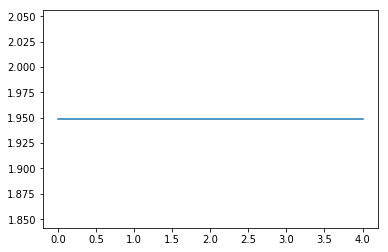

In [60]:
plt.plot(acc_x_diff)

In [ ]:
test_file.close()

# Following is some code to check if the information within the hdf5 files is correct


data_root = "/data/outside_data/BDDUnzipped/structure_for_code/tfrecords/training"

filename = '9530facd-cb0abe12.h5'

testfile = h5py.File(os.path.join(data_root,filename),'r')

def convert_images(encoded_images):
    return [cv2.imdecode(np.fromstring(encoded_img, dtype=np.uint8), -1) for encoded_img in encoded_images]

decoded_images = convert_images(testfile['image']['encoded'])

for i, img in enumerate(decoded_images):
    position = (testfile['latitude'][i],testfile['longitude'][i])
    #print position
    img = write_text(img,text=position)
    cv2.imshow('test',img)
    cv2.waitKey(30)
    
    if i > 200:
        break
        
cv2.destroyAllWindows()

# So now I know the freshly added lat and long to the hdf5 file works


### The next lines of code are old code to play around with the actions

model.eval()
debug = True

topk = 5 # It became evident that the top 5 NNs are sufficient for the best results
steer_eval = {}

correct = 0.
correct_past = 0.
correct_future = 0.

total = 0
observed_timestep = 3

trainFeatures = lemniscate.memory.t()

trainLabels = torch.LongTensor(train_loader.dataset.train_labels).cuda()

stat_data = {}
stat_data['action_correlations'] = []

start_time = time.time()
img_id = 13


input_imgs = torch.unsqueeze(train_loader.dataset.__getitem__(img_id)[0],0)
targets = torch.unsqueeze(train_loader.dataset.__getitem__(img_id)[1],0)

for i in range(0,6)*4:
    with torch.no_grad():

        criterion = nn.BCELoss(reduce=False).cuda()
        bce = lambda t1, t2: criterion(t1, t2).mean().flatten()
        pixel_loss = nn.MSELoss()

        targets = targets.cuda(async=True)
        input_imgs = input_imgs.cuda(async=True)

        og_targets = targets.clone()

        input_imgs = input_imgs[:,0:int((n_frames/2)*3),:,:] #extract only img 1 through 3
        targets_orig = targets.clone()

        targets = targets[:,0:int(n_frames/2)] #extract steers first 3 targets

        # The next lines are used to investigate how the images change
        # with different actions as input
        action_prob = np.array([int(j == 3) for j in range(6)])

        #targets = torch.from_numpy(np.array([[action_prob,
        # action_prob,
        # action_prob]])).float().cuda()

        features = model(input_imgs, targets)

        dist = torch.mm(features, trainFeatures)

        yd, yi = dist.topk(topk, dim=1, largest=True, sorted=True)
        candidates = trainLabels.view(1,-1).expand(batchSize, -1)
        retrieval = torch.gather(candidates, 1, yi)

        retrieval = retrieval.narrow(1, 0, topk).clone()
        yd = yd.narrow(1, 0, topk)

        min_val = yd.min()
        max_val = yd.max()
        a = 1 / (max_val - min_val)
        b = 1 - a * max_val
        yd_mapped = yd.clone().mul(a).add(b)

        image_steering_labels = defaultdict()

        action_correlations = []
        img_retrievals = []

        show_images = True

        for top_id in range(topk):

            ret_ind = int(retrieval[0, top_id])
            action_label_past = train_loader.dataset.__getlabel__(ret_ind)[0][0:3]

            #train_test_retrieval = val_loader.dataset.run_files[top_id].data_point()
            targets_past = targets_orig[0][0:3]

            action_correlations.append(bce(action_label_past,targets_past).cpu().numpy())

            if show_images: img_retrievals.append(train_loader.dataset.__getitem__(ret_ind)[0])


        #text_on_img = train_loader.dataset.__getlabel__(retrieval[0, 0])[0]
        if show_images: ret_imgs_cv2_comp = [(img_retrievals[i][6:9]+0.5).transpose(1,2).transpose(0,2) for i in range(topk)]

        #avg_img = torch.stack(ret_imgs_cv2_comp).mean(0)        
        if show_images: query_img = (input_imgs[0,0:3,:,:]+0.5).transpose(1,2).transpose(0,2)


        if show_images: show_img = torch.cat(ret_imgs_cv2_comp,1)#.cpu().numpy()
        if show_images: show_img = torch.cat((query_img,show_img),1).cpu().numpy()

        #mse_pixel_loss = pixel_loss(Variable(avg_img), Variable(query_img))

        stat_data['action_correlations'].append(action_correlations)

        # The following can be used to write directly on images
        #show_img = write_text(show_img,mse_pixel_loss.cpu().numpy())
        if show_images: cv2.imshow('test',show_img)
        if show_images: cv2.waitKey(3)

        input_imgs = torch.unsqueeze(train_loader.dataset.__getitem__(ret_ind)[0],0)


if show_images: cv2.destroyAllWindows()
